First Step on Deep Learning Using Tensorflow
=============


各位同学们，我们在第九课上已经给大家介绍过了基础的深度学习知识。 这种最简单的网络是上一层网络全部链接到下一层网络，所以也称作 fully-connected（全连接） 网络。 

在本次作业中，我们将使用经典数据集 mnist的升级版，notMNIST构建神经网络进行图像分类。 

本次作业，你需要完成1, 2, 3三个联系。 能够掌握：

1. 数据预处理的知识
2. 深度学习程序的构建方式
3. 训练集、测试集、验证集
4. 神经网络的基础知识
5. 图计算网络
6. 正则化

等非常重要的知识 



## Assignment 1

------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

鉴于网络环境，直接手动下载解压，完成该Assignment1 数据获取任务

------------

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
import matplotlib
print(matplotlib.matplotlib_fname())

D:\Design Software\Anaconda\envs\py36\lib\site-packages\matplotlib\mpl-data\matplotlibrc


Text(0, 0.5, 'BBB')

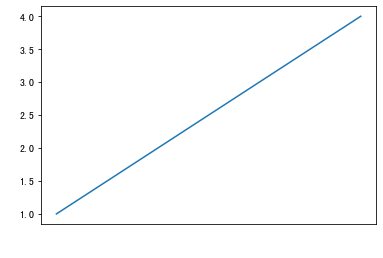

In [9]:
plt.plot([1,2,3,4])
plt.xlabel('AAA')
plt.ylabel('BBB')

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [4]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

#train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
#test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [10]:
os.path.splitext('notMNIST_large.tar.gz')

('notMNIST_large.tar', '.gz')

In [11]:
os.path.isdir('notMNIST_large')

False

In [0]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz, 得到notMNIST_large
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


## Problem 1

---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [20]:
np.ndarray(shape=(1, 2, 2), dtype=np.float32) #random

array([[[1.e-45, 1.e-45],
        [1.e-45, 0.e+00]]], dtype=float32)

In [28]:
image_file = '../picture/test.png'
imageio.imread(image_file).astype(float).shape #读取图片，以数组形式返回

(28, 28)

In [29]:
np.mean??

In [31]:
pickle.dump??

In [32]:
pickle.HIGHEST_PROTOCOL??

In [4]:
image_size = 28  # Pixel width and height. #图片28x28像素的，相当于用28x28矩阵表示
pixel_depth = 255.0  # Number of levels per pixel.#每个像素的深度，即用多大来描述该像素 0-255

#读取一个文件下的所有图片，并以数组形式返回图片的数组数据，shape =（图片个数, image_size, image_size）
def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)#存储图片数据的数组
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - 
                        pixel_depth / 2) / pixel_depth #把图片数据进行归一化处理，使得所有值在-0.5-0.5之间
            if image_data.shape != (image_size, image_size):#去除图片像素大小不是28x28的图片
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data #把
            num_images = num_images + 1
            
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
  
#将每一类图片读以数组方式读取出来，并保持成一个pickle文件
def maybe_pickle(file_path, min_num_images_per_class, force=False):
    dataset_names = []
    data_folders = os.listdir(file_path)
    data_folders = [os.path.join(file_path, name) for name in data_folders]
    
    for folder in data_folders:
        if os.path.isfile(folder): continue
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
          # You may override by setting force=True.
          print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

#train_datasets = maybe_pickle(train_folders, 45000)
#test_datasets = maybe_pickle(test_folders, 1800)

In [5]:
train_file_path = 'E:\\MYGIT\\DataSources\\notMNIST\\notMNIST_large'
test_file_path = 'E:\\MYGIT\\DataSources\\notMNIST\\notMNIST_small'
test_datasets = maybe_pickle(test_file_path, 1800)
train_datasets = maybe_pickle(train_file_path, 45000)

E:\MYGIT\DataSources\notMNIST\notMNIST_small\A.pickle already present - Skipping pickling.
E:\MYGIT\DataSources\notMNIST\notMNIST_small\B.pickle already present - Skipping pickling.
E:\MYGIT\DataSources\notMNIST\notMNIST_small\C.pickle already present - Skipping pickling.
E:\MYGIT\DataSources\notMNIST\notMNIST_small\D.pickle already present - Skipping pickling.
E:\MYGIT\DataSources\notMNIST\notMNIST_small\E.pickle already present - Skipping pickling.
E:\MYGIT\DataSources\notMNIST\notMNIST_small\F.pickle already present - Skipping pickling.
E:\MYGIT\DataSources\notMNIST\notMNIST_small\G.pickle already present - Skipping pickling.
E:\MYGIT\DataSources\notMNIST\notMNIST_small\H.pickle already present - Skipping pickling.
E:\MYGIT\DataSources\notMNIST\notMNIST_small\I.pickle already present - Skipping pickling.
E:\MYGIT\DataSources\notMNIST\notMNIST_small\J.pickle already present - Skipping pickling.
E:\MYGIT\DataSources\notMNIST\notMNIST_large\A.pickle already present - Skipping pickling.

In [7]:
train_datasets[1]

'E:\\MYGIT\\DataSources\\notMNIST\\notMNIST_large\\B.pickle'

In [47]:
os.path.isdir??

## Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [71]:
%matplotlib inline

In [74]:
with open(test_datasets[1], 'rb') as f:
    data = pickle.load(f)
    print('Total images in', test_datasets[1], ':', len(data)) 

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_small\B.pickle : 1873


In [84]:
plt.imshow??

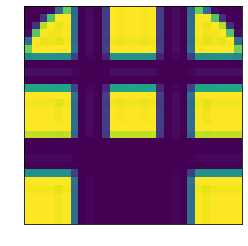

In [112]:
image_file = '../picture/test.png'
image = imageio.imread(image_file).astype(float) #读取图片，以数组形式返回
plt.imshow(image)

In [8]:
import matplotlib.pyplot as plt
import random

#从每个pickle中随机取50个数据图片作为展示
def load_and_display_pickle(pickle_flie, title=None):
    with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
            print('Total images in', pickle_file, ':', len(data)) 
            
    random_index = list(random.sample(range(len(data)), 50))
    fig, axes = plt.subplots(5, 10, figsize=(10,5))
    
    if title: fig.suptitle(title, fontsize=24, fontweight='bold', C='white')
    for i in range(50):
        axes[i//10][i].imshow(data[random_index[i],:,:])
        axes[i//10][i].set_axis_off()
    plt.show()

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_small\A.pickle : 1872


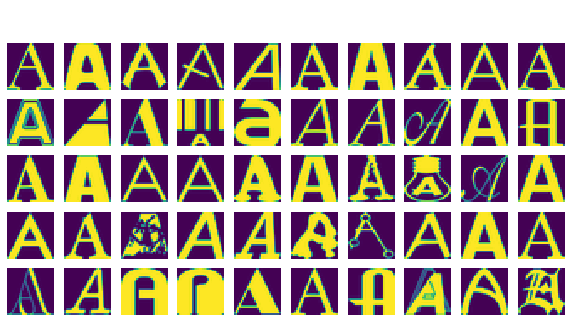

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_small\B.pickle : 1873


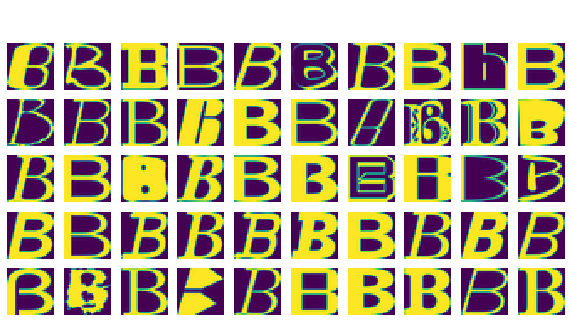

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_small\C.pickle : 1873


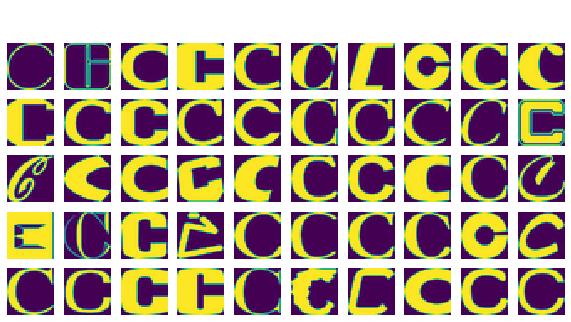

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_small\D.pickle : 1873


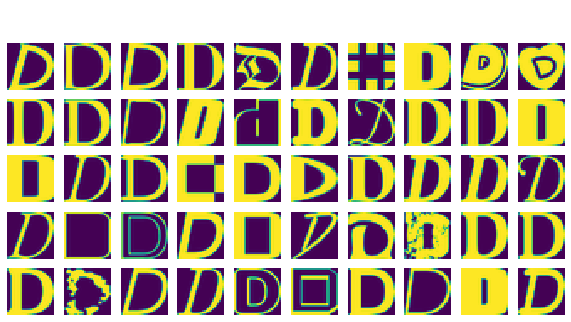

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_small\E.pickle : 1873


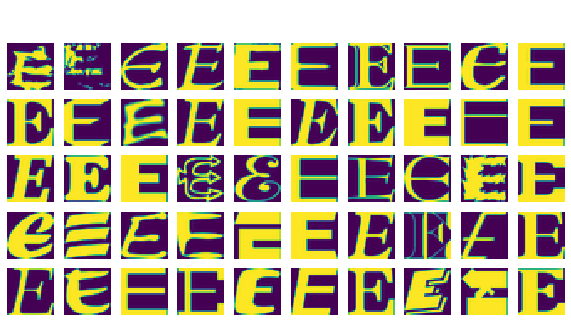

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_small\F.pickle : 1872


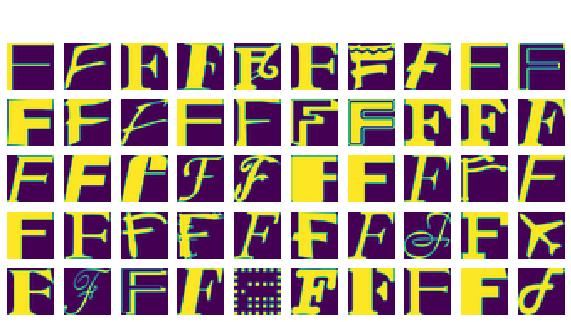

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_small\G.pickle : 1872


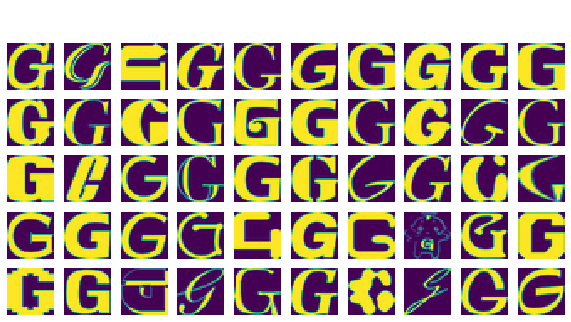

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_small\H.pickle : 1872


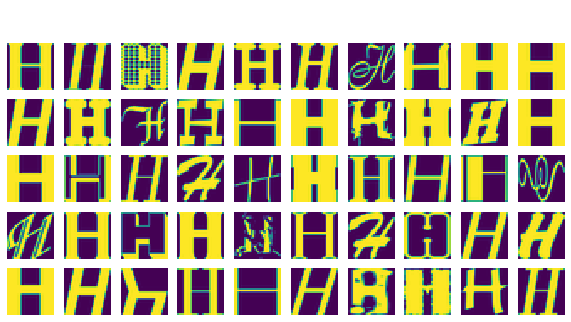

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_small\I.pickle : 1872


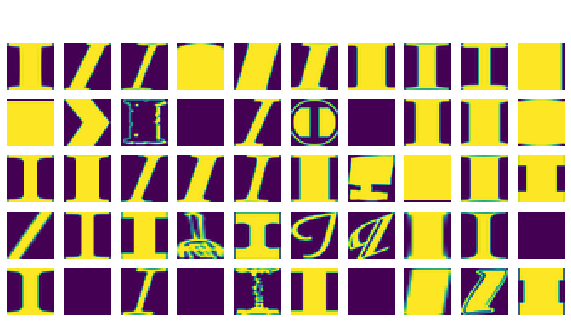

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_small\J.pickle : 1872


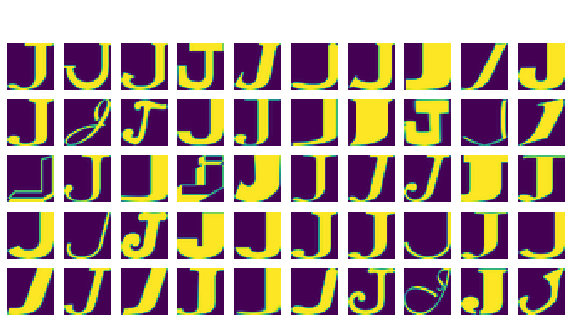

In [122]:
for pickle_file in test_datasets:
    title_name = pickle_file[-8] + ' image'
    load_and_display_pickle(pickle_file, title_name)

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_large\A.pickle : 52909


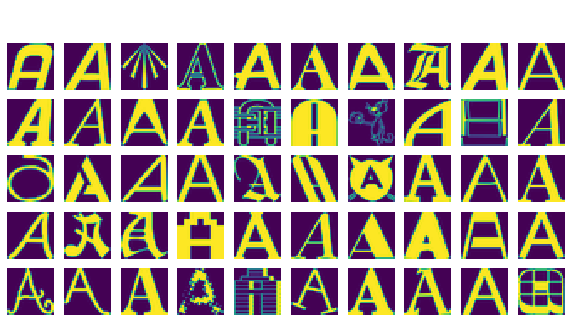

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_large\B.pickle : 52911


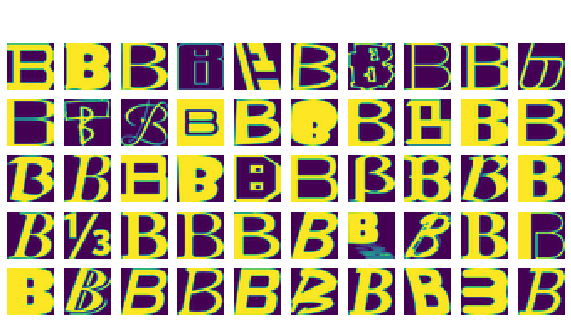

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_large\C.pickle : 52912


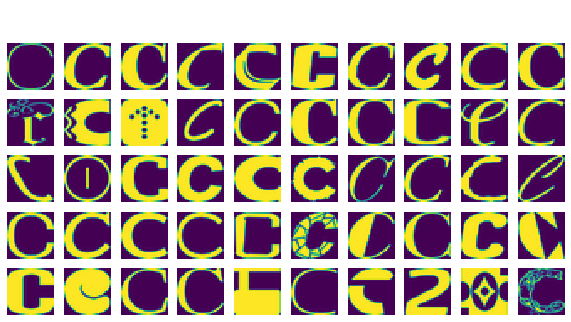

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_large\D.pickle : 52911


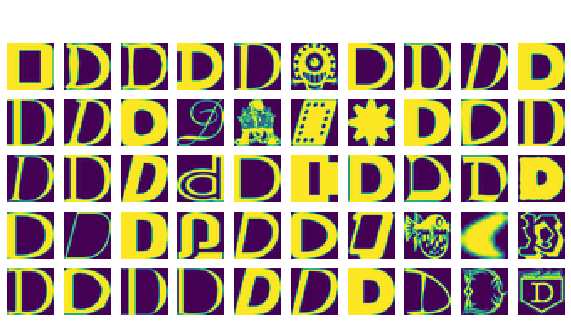

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_large\E.pickle : 52912


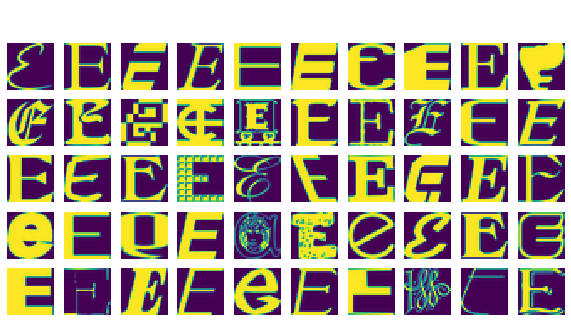

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_large\F.pickle : 52912


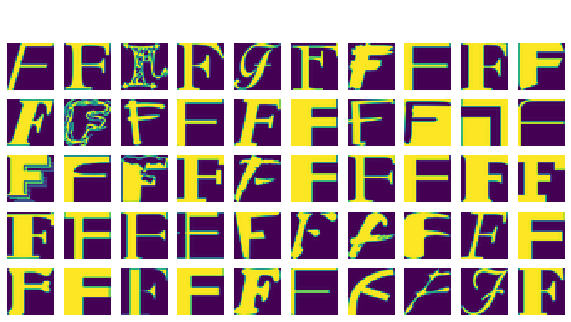

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_large\G.pickle : 52912


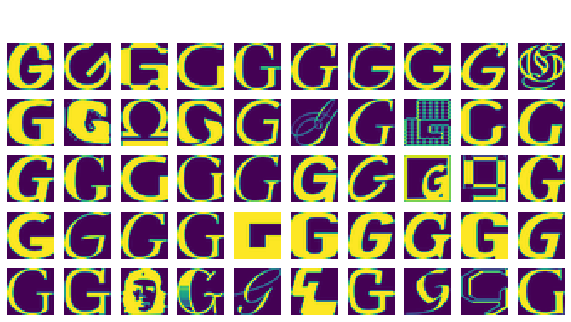

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_large\H.pickle : 52912


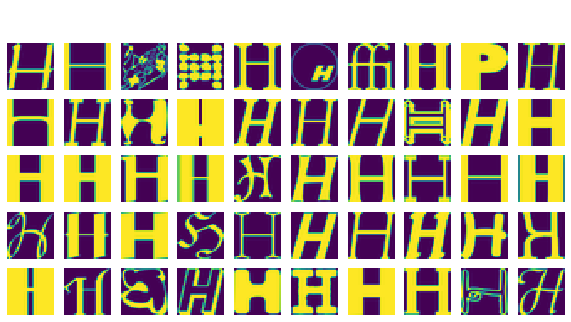

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_large\I.pickle : 52912


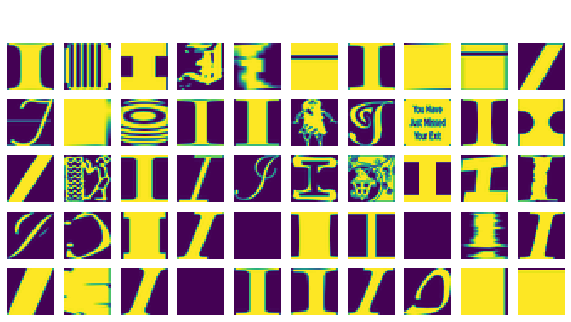

Total images in E:\MYGIT\DataSources\notMNIST\notMNIST_large\J.pickle : 52911


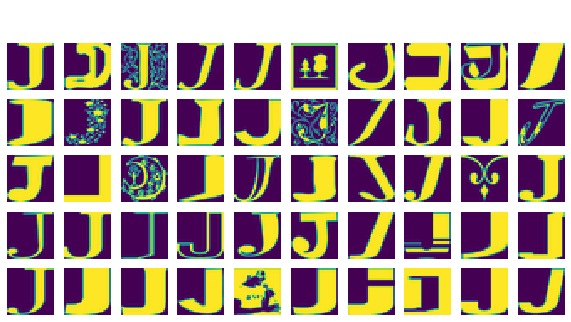

In [123]:
for pickle_file in train_datasets:
    title_name = pickle_file[-8] + ' image'
    load_and_display_pickle(pickle_file, title_name)

## Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

#每个类别选取相同数量额训练数据和验证数据
def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    image_size = 28
    
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)#初始化验证集
    train_dataset, train_labels = make_arrays(train_size, image_size)#初始化训练集
    vsize_per_class = valid_size // num_classes ##使得每个类别的样本数一致
    tsize_per_class = train_size // num_classes ##使得每个类别的样本数一致

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]#
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
                
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
    
    return valid_dataset, valid_labels, train_dataset, train_labels

In [10]:
pretty_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

In [11]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [142]:
arr = np.arange(9).reshape((3, 3))
arr

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [143]:
aa = np.random.permutation(2)
aa

array([1, 0])

In [145]:
arr[aa,:]

array([[3, 4, 5],
       [0, 1, 2]])

In [12]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Finally, let's save the data for later reuse:

In [18]:
#将以上处理好的数据保存成一个pickle文件
data_root = 'E:/MYGIT/DataSources/notMNIST'
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
print(pickle_file)
try:
    with open(pickle_file, 'wb') as f:
        save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)

E:/MYGIT/DataSources/notMNIST\notMNIST.pickle


In [149]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


## Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

### **比较两个图片对应的数组是否绝对相等**


In [159]:
from collections import defaultdict
##提取出dataset1和dataset2中一样的图片，返回（索引：索引）的字典
def extract_overlap(dataset1, dataset2):
    overlap = defaultdict(list)
    for i, imgi in enumerate(dataset1):
        for j,imgj in enumerate(dataset2):
            if np.array_equal(imgi, imgj):
                overlap[i] += [j]
    return overlap


##从target_dataset中选取前8个与source_dataset某一与的图片相似的图片，
def display_overlap(overlap, source_dataset, target_dataset):
    item = random.choice(list(overlap.keys()))
    imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
    plt.suptitle(item, c='white')
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img)

In [154]:
%%time
overlap_dict = extract_overlap(test_dataset[:50],train_dataset)

Wall time: 1min 39s


Number of overlaps: 5


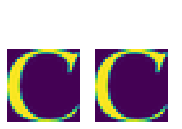

In [226]:
print('Number of overlaps:', len(overlap_dict.keys()))
display_overlap(overlap_dict,test_dataset[:50],train_dataset)

### **比较两个图片是否近似相等**

numpy里的比较方法allclose太过严格，考虑到两张图片在某个像素点相差较大而其他一致时候，图片也是看起来一样的，而allclose会比较每一个像素点的差值，故不大使用我们这里的情况。 所以我们这里用误差均值来衡量相似度，在一定程度上效果会好些


In [169]:
MAX_NORM = 10
def extract_overlap_simi(dataset1, dataset2):
    overlap = defaultdict(list)
    for i, imgi in enumerate(dataset1):
        for j,imgj in enumerate(dataset2):
            diff = imgi - imgj
            n_norm = np.sum(abs(diff))
            if n_norm < MAX_NORM:
                overlap[i] += [j]
    return overlap

In [170]:
%%time
overlap_dict_simi = extract_overlap_simi(test_dataset[:50], train_dataset)

Wall time: 3min 5s


Number of overlaps: 13


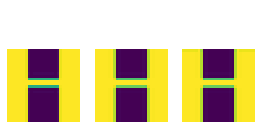

In [179]:
print('Number of overlaps:', len(overlap_dict_simi.keys()))
display_overlap(overlap_dict_simi, test_dataset[:50], train_dataset)

### 优化以上比较方法
以上的方法都是逐个直接比较，导致了当数据量增大时，花费时间过长，代码效率不高。试着用以下等方法进行优化
- numpy里的where筛选出绝对差值的均值小于某常数的图片数据
- hash比较

where方法

---

In [189]:
aa = np.arange(1,9).reshape((2,2,2))
bb = np.array([[1,1],[1,1]])
tt = aa - bb
tt

array([[[0, 1],
        [2, 3]],

       [[4, 5],
        [6, 7]]])

In [196]:
ss = np.sum(np.sum(tt,axis=1),1)
ss

array([ 6, 22])

In [206]:
ss = np.arange(10,20)
sss = np.where(ss>4)
print(sss[0])
print(type(sss[0]))

[0 1 2 3 4 5 6 7 8 9]
<class 'numpy.ndarray'>


In [211]:
MAX_NORM = 10
def extract_overlap_where(dataset1, dataset2):
    overlap = defaultdict(list)
    for i, imgi in enumerate(dataset1):
        diff = dataset2 - imgi #会自动广播
        n_norm = np.sum(np.sum(np.abs(diff),1),1)
        duplicates = np.where(n_norm < MAX_NORM)#返回的是索引值
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

In [212]:
%%time
overlap_dict_where = extract_overlap_where(test_dataset[:50], train_dataset)
##可见结果是一致的，但时间从3min减少到不到1min

Wall time: 45.6 s


Number of overlaps: 13


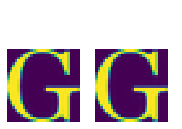

In [217]:
print('Number of overlaps:', len(overlap_dict_where.keys()))
display_overlap(overlap_dict_where, test_dataset[:50], train_dataset)

hash 方法

但hash方法只能用来检测两张图片是否完全一致，而不能检查相似的图片，那怎么处理呢？可以尝试以下一些技巧

- locally sensitive hashing
- perceptual hashing
- difference hashing

而且hash方法有可能找到比实际多的相同图片，这是由于hash冲突，不同图片可能会有相同的hash值，这个例子没有体现出来
但这不影响，因为量少，而且我们本来就要把这些相同的图片移除

---

In [224]:
import hashlib
MAX_NORM = 10
def extract_overlap_hash(dataset1, dataset2):
    overlap = defaultdict(list)
    #hashlib.sha256(img).hexdigest()是一种hash函数，它把根据数据生成一段256位的信息摘要
    dataset_hash_1 = [hashlib.sha256(img).hexdigest() for img in dataset1]
    dataset_hash_2 = [hashlib.sha256(img).hexdigest() for img in dataset2]
    for i, hash1 in enumerate(dataset_hash_1):
        for j,hash2 in enumerate(dataset_hash_2):
            if hash1 == hash2:
                overlap[i] += [j]
    return overlap

In [234]:
%%time
overlap_dict_hash = extract_overlap_hash(test_dataset[:200], train_dataset)
#可见速度快了更多注意，这里数据从50变成200

Wall time: 6.03 s


Number of overlaps: 22


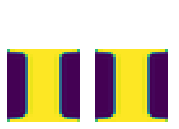

In [235]:
print('Number of overlaps:', len(overlap_dict_hash.keys()))
display_overlap(overlap_dict_hash, test_dataset[:200], train_dataset)

In [229]:
import hashlib
MAX_NORM = 10
def extract_overlap_hash_where(dataset1, dataset2):
    overlap = defaultdict(list)
    #hashlib.sha256(img).hexdigest()是一种hash函数，它把根据数据生成一段256位的信息摘要
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset2])
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

In [236]:
%%time
overlap_dict_hash_where = extract_overlap_hash_where(test_dataset[:200], train_dataset)
#可见hash+where方法速度又提升了

Wall time: 4.06 s


Number of overlaps: 22


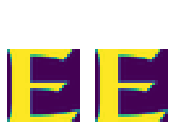

In [237]:
print('Number of overlaps:', len(overlap_dict_hash_where.keys()))
display_overlap(overlap_dict_hash_where, test_dataset[:200], train_dataset)

使用局部敏感hash方法找出相似的图片

---

In [252]:
#!pip install lshash3

In [262]:
from lshash.lshash import LSHash

In [315]:
>>> lsh = LSHash(6, 8)
>>> lsh.index(np.array([1,2,3,4,5,6,7,8]))
>>> lsh.index([2,3,4,5,6,7,8,9])
>>> lsh.index([10,12,99,1,5,31,2,3])
>>> lsh.index([8,12,99,1,5,31,2,3])
>>> lsh.index([10,5,99,1,5,31,2,3])
>>> lsh.index([10,20,99,1,5,31,2,3])
>>> lsh.index([8,8,10,11,12,13,14,15])
>>> lsh.query([1,5,3,4,5,6,7,7])[0][1]

10

In [305]:
lsh.query??

In [316]:
from lshash.lshash import LSHash
MAX_NORM = 10
def extract_overlap_lshash_where(dataset1, dataset2):
    overlap = defaultdict(list)
    #hashlib.sha256(img).hexdigest()是一种hash函数，它把根据数据生成一段256位的信息摘要
    lsh = LSHash(256, 28*28)
    for data in dataset2:
        lsh.index(data)
    for i, data in enumerate(dataset1):
        result = lsh.query(data,1)
        if len(result):
            if result[0][1] < MAX_NORM: #这里的MAX_NORM比较关系需要实验获得较优参数
                overlap[i] = result
    return overlap

##从target_dataset中选取前8个与source_dataset某一与的图片相似的图片，
def display_lshash(overlap, source_dataset, target_dataset):
    item = random.choice(list(overlap.keys()))
    target = [np.array(i[0]).reshape((28,28)) for i in overlap[item]]
    imgs = np.concatenate(([source_dataset[item]], target[:8]))
    plt.suptitle(item, c='white')
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img)

In [318]:
%%time
test_flat = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
train_flat = train_dataset.reshape(train_dataset.shape[0], 28 * 28)
overlap_dict_lshash = extract_overlap_lshash_where(test_flat[:50], train_flat)

Wall time: 2min 16s


Number of overlaps: 22


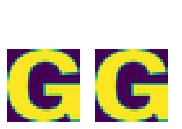

In [321]:
print('Number of overlaps:', len(overlap_dict_hash_where.keys()))
display_lshash(overlap_dict_lshash,test_dataset[:200],train_dataset)

可见时间由5min变为2min，其实主要是lshash模块数据只能一个一个进行输入，导致大量时间浪费在这里

如果想要更优化该方法，可能需要自己设计一个lshash函数来进行测试，由于时间关系这里就不深入。可作为额外作业，到时再继续深入

另外我们设置的MAX_NORM为10 ,注意到我们得到overlaps是22，这和完全相同图片的数量一致，可见，我们这里的MAX_NORM是过小了，太严格了，可以把MAX_NORM设置地大些

用以上分析的方法删除重复数据

---

In [238]:
np.delete??

In [13]:
import hashlib
MAX_NORM = 10
#删除测试集的中与训练集重复的数据
def delete_overlap(dataset1, dataset2, label1):
    overlap = []
    #hashlib.sha256(img).hexdigest()是一种hash函数，它把根据数据生成一段256位的信息摘要
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset2])
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap.append(i)
    return np.delete(dataset1,overlap, 0), np.delete(label1, overlap)

In [14]:
test_dataset_sanit, test_labels_sanit = delete_overlap(test_dataset[:200], 
                                                 train_dataset, test_labels[:200])
print('Overlapping images removed: ', len(test_dataset[:200]) - len(test_dataset_sanit))

Overlapping images removed:  24


In [15]:
%%time 
test_dataset_sanit, test_labels_sanit = delete_overlap(test_dataset, train_dataset, test_labels)
print('Overlapping images removed: ', len(test_dataset) - len(test_dataset_sanit))

Overlapping images removed:  1281
Wall time: 1min


In [16]:
%%time 
valid_dataset_sanit, valid_labels_sanit = delete_overlap(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed: ', len(valid_dataset) - len(valid_dataset_sanit))

Overlapping images removed:  1016
Wall time: 59.1 s


In [17]:
data_root = 'E:/MYGIT/DataSources/notMNIST'
pickle_file = os.path.join(data_root, 'notMNIST_remove_oevrlap.pickle')
print(pickle_file)
try:
    with open(pickle_file, 'wb') as f:
        save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset_sanit,
        'valid_labels': valid_labels_sanit,
        'test_dataset': test_dataset_sanit,
        'test_labels': test_labels_sanit,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)

E:/MYGIT/DataSources/notMNIST\notMNIST_remove_oevrlap.pickle


## Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [330]:
pretty_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}
def plt_label_img(dataset, labels):
    items = random.sample(range(len(labels)), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(pretty_labels[labels[item]], c='white')
        plt.imshow(dataset[item])

In [322]:
from sklearn.linear_model import LogisticRegression

In [323]:
regr = LogisticRegression()
X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
y_test = test_labels

In [325]:
sample_size = 50
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

D:\Design Software\Anaconda\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Design Software\Anaconda\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 146 ms


0.617

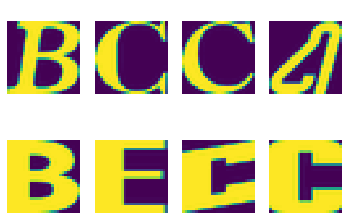

In [331]:
pred_labels = regr.predict(X_test[:100])
plt_label_img(test_dataset[:100], pred_labels)

In [332]:
sample_size = 100
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

D:\Design Software\Anaconda\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Design Software\Anaconda\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 148 ms


0.7577

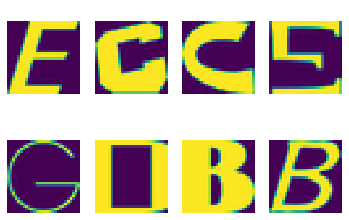

In [333]:
pred_labels = regr.predict(X_test[:100])
plt_label_img(test_dataset[:100], pred_labels)

In [334]:
#改变训练样本数
sample_size = 1000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

D:\Design Software\Anaconda\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Design Software\Anaconda\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Wall time: 3.03 s


0.8389

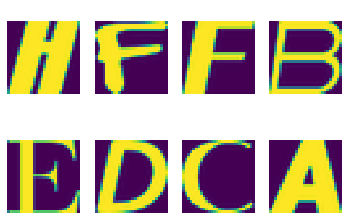

In [335]:
pred_labels = regr.predict(X_test[:500])
plt_label_img(test_dataset[:500], pred_labels)

In [ ]:
#改变逻辑回归求解器方法
regr2 = LogisticRegression(solver='sag')
sample_size = 10000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr2.fit(X_train, y_train)
regr2.score(X_test, y_test)

D:\Design Software\Anaconda\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Design Software\Anaconda\envs\py36\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
pred_labels = regr.predict(X_test[:500])
plt_label_img(test_dataset[:500], pred_labels)